In [1]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import display

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import warnings; warnings.filterwarnings('ignore')
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

In [2]:
train_df = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/train_meta.csv', index_col=0)
train_signal = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/train_signal.csv')

valid_df = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/valid_meta.csv', index_col=0)
valid_signal = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/valid_signal.csv')

test_df = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/test_meta.csv', index_col=0)
test_signal = pd.read_csv('D:/23020407 Dang Minh Nguyet/Seminar/BTL-Seminar/data/ptb-xl-dataset-reformatted/test_signal.csv')

print(train_df.shape)

train_df

(17441, 36)


,age,sex,height,weight,nurse,site,device,NORM,MI,STTC,...,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI,strat_fold
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
2,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,2
3,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,5
4,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,3
5,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1,0,0,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,63.0,0,NaN,NaN,1.0,2.0,AT-60 3,0,0,0,...,0,0,0,0,0,0,0,0,0,7
21833,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,0,0,1,...,0,0,0,0,0,0,0,0,0,7
21834,93.0,0,NaN,NaN,1.0,2.0,AT-60 3,1,0,0,...,0,0,0,0,0,0,0,0,0,4


In [3]:
class PTBXLDatasetPreprocesser():
    def __init__(self):
        pass
    
    def save(self, filename):
        data = {
            'superclass_cols': self.superclass_cols,
            'subclass_cols': self.subclass_cols,
            'meta_num_cols': self.meta_num_cols,
            'meta_num_means': self.meta_num_means,
            'min_max_scaler': self.min_max_scaler,
            'meta_cat_cols': self.meta_cat_cols,
            'cat_lablers': self.cat_lablers,
        }
        pd.to_pickle(data, filename)
    
    def load(self, filename):
        data = pd.read_pickle(filename)
        self.min_max_scaler = data['min_max_scaler']
        self.cat_lablers = data['cat_lablers']
        
    def fit(self, x, y):
        x = x.copy()
        y = y.copy()
        
        self.superclass_cols = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
        
        self.subclass_cols = [col for col in y.columns if 'sub_' in col]
        
        self.meta_num_cols = ['age', 'height', 'weight']
        self.meta_num_means = []
        for col in self.meta_num_cols:
            print(col, y[col].mean())
            y[col] = y[col].fillna(y[col].mean())
            self.meta_num_means += [y[col].mean()]
            
        self.min_max_scaler = MinMaxScaler().fit(y[self.meta_num_cols])
        
        self.meta_cat_cols = ['sex'] #, 'nurse', 'device']
        self.cat_lablers = [LabelEncoder().fit(y[col].fillna('none').astype(str)) for col in self.meta_cat_cols]
        return self
    
    def transform(self, x, y):
        
        channel_cols = x.columns.tolist()[1:]
        
        ret = []
        x = x[channel_cols].values.reshape(-1, 1000, 12)
        print(x.shape)
        ret += [x] # signal
        
        y_ = y.copy()
        
        for i, col in enumerate(self.meta_num_cols):
            y_[col] = y_[col].fillna(self.meta_num_means[i])
        y_[self.meta_num_cols] = self.min_max_scaler.transform(y_[self.meta_num_cols])
        y_[self.meta_num_cols] = np.clip(y_[self.meta_num_cols], 0., 1.) # prevent extreme value far from train set
        
        ret += [y_[self.meta_num_cols]] # meta num features
        
        for i, col in enumerate(self.meta_cat_cols):
            y_[col] = y_[col].fillna('none').astype(str)
            y_[col] = self.cat_lablers[i].transform(y_[col])
        
        ret += [y_[self.meta_cat_cols]] # meta cat features
        
        if np.isin(self.superclass_cols, y.columns).sum() == len(self.superclass_cols):
            ret += [y[self.superclass_cols].fillna(0).astype(int)] # superclass targets
        
        if np.isin(self.subclass_cols, y.columns).sum() == len(self.subclass_cols):
            ret += [y[self.subclass_cols].fillna(0).astype(int)] # subclass targets
        
        return ret

In [4]:
data_preprocessor = PTBXLDatasetPreprocesser()
data_preprocessor.fit(train_signal, train_df)
train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass = data_preprocessor.transform(train_signal, train_df)
valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass = data_preprocessor.transform(valid_signal, valid_df)
test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

print(train_signal.shape)
print(valid_meta_num_feats.isna().sum(), valid_meta_cat_feats.isna().sum(), valid_superclass.isna().sum(), valid_subclass.isna().sum())

display(train_meta_num_feats)
display(train_meta_cat_feats)
display(train_superclass)
display(train_subclass)

age 59.63709074169975
height 166.68908469699693
weight 70.69599447513812
(17441, 1000, 12)
(2193, 1000, 12)
(2203, 1000, 12)
(17441, 1000, 12)
age       0
height    0
weight    0
dtype: int64 sex    0
dtype: int64 NORM    0
MI      0
STTC    0
CD      0
HYP     0
dtype: int64 sub_NORM         0
sub_IMI          0
sub_STTC         0
sub_NST_         0
sub_LVH          0
sub_LAFB/LPFB    0
sub_RVH          0
sub_RAO/RAE      0
sub_IRBBB        0
sub_IVCD         0
sub_LMI          0
sub_AMI          0
sub__AVB         0
sub_ISCA         0
sub_ISC_         0
sub_SEHYP        0
sub_ISCI         0
sub_CRBBB        0
sub_CLBBB        0
sub_LAO/LAE      0
sub_ILBBB        0
sub_WPW          0
sub_PMI          0
dtype: int64


,age,height,weight
ecg_id,,,
1,0.580645,0.791572,0.282927
2,0.182796,0.791572,0.317073
3,0.376344,0.791572,0.312195
4,0.236559,0.791572,0.375610
5,0.182796,0.791572,0.317073
...,...,...,...
21832,0.655914,0.791572,0.320468
21833,0.698925,0.791572,0.320468
21834,0.978495,0.791572,0.320468


,sex
ecg_id,
1,1
2,0
3,1
4,0
5,1
...,...
21832,0
21833,1
21834,0


,NORM,MI,STTC,CD,HYP
ecg_id,,,,,
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0
...,...,...,...,...,...
21832,0,0,0,1,0
21833,0,0,1,0,0
21834,1,0,0,0,0


,sub_NORM,sub_IMI,sub_STTC,sub_NST_,sub_LVH,sub_LAFB/LPFB,sub_RVH,sub_RAO/RAE,sub_IRBBB,sub_IVCD,...,sub_ISCA,sub_ISC_,sub_SEHYP,sub_ISCI,sub_CRBBB,sub_CLBBB,sub_LAO/LAE,sub_ILBBB,sub_WPW,sub_PMI
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21832,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
21833,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21834,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Train


In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [6]:
class ECGDataset(Dataset):
    def __init__(self, signals, num_metas, cat_metas, superclass_labels=None, subclass_labels=None):
        self.signals = signals
        self.num_metas = num_metas
        self.cat_metas = cat_metas
        self.superclass_labels = superclass_labels
        self.subclass_labels = subclass_labels
        
    def __len__(self):
        return self.signals.shape[0]
    
    def __getitem__(self, idx):
        ret = []
        ret += [self.signals[idx,:]]
        ret += [self.num_metas.values[idx,:]]
        ret += [self.cat_metas.values[idx,:]]
        
        if self.superclass_labels is not None:
            ret += [self.superclass_labels.values[idx,:]]
        
        if self.subclass_labels is not None:
            ret += [self.subclass_labels.values[idx,:]]
        
        return ret

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from spikingjelly.activation_based import neuron, functional, surrogate

class TemporalAttention(nn.Module):
    def __init__(self, in_channels, timesteps):
        super().__init__()
        self.query = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)
        
    def forward(self, x):
        # x shape: [B, C, T]
        Q = self.query(x).permute(0, 2, 1)  # [B, T, C']
        K = self.key(x)                     # [B, C', T]
        V = self.value(x)                   # [B, C, T]
        
        attn_scores = torch.bmm(Q, K) / (K.shape[1] ** 0.5)  # [B, T, T]
        attn_weights = self.softmax(attn_scores)             # [B, T, T]
        
        V_perm = V.permute(0, 2, 1)                          # [B, T, C]
        out = torch.bmm(attn_weights, V_perm)               # [B, T, C]
        out = out.permute(0, 2, 1)                           # [B, C, T]

        return out + x  # Residual connection

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.shared_mlp = nn.Sequential(
            nn.Conv1d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared_mlp(self.avg_pool(x))
        max_out = self.shared_mlp(self.max_pool(x))
        return x * self.sigmoid(avg_out + max_out)

class ECGClassifier_SNN_CAM(nn.Module):
    def __init__(self, signal_channel_size, timesteps, per_cat_nunique, embed_size,
                 num_size, hidden, n_superclass, n_subclass):
        super().__init__()

        conv_channels = [64, 128, 256]
        self.conv1 = nn.Conv1d(signal_channel_size, conv_channels[0], kernel_size=3, padding=1)
        self.lif1 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid(), detach_reset=True)

        self.conv2 = nn.Conv1d(conv_channels[0], conv_channels[1], kernel_size=3, padding=1)
        self.lif2 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid(), detach_reset=True)

        self.cam = ChannelAttention(conv_channels[1])  # Insert CAM here
        self.temporal_attn = TemporalAttention(in_channels=conv_channels[1], timesteps=timesteps // 4)  # adjust for pooling

        self.conv3 = nn.Conv1d(conv_channels[1], conv_channels[2], kernel_size=3, padding=1)
        self.lif3 = neuron.LIFNode(surrogate_function=surrogate.Sigmoid(), detach_reset=True)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten_signal_dim = conv_channels[2]

        self.embeds = nn.ModuleList([nn.Embedding(v, embed_size) for v in per_cat_nunique])
        total_embed_dim = embed_size * len(per_cat_nunique)

        self.classifier = nn.Sequential(
            nn.Linear(self.flatten_signal_dim + total_embed_dim + num_size, hidden * 2),
            nn.BatchNorm1d(hidden * 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )

        self.out_super = nn.Linear(hidden * 2, n_superclass)
        self.out_sub = nn.Linear(hidden * 2, n_subclass)

    def forward(self, signal, num_meta, cat_meta):
        signal = signal.permute(0, 2, 1)  # [B, C, T]

        x = self.pool(self.lif1(self.conv1(signal)))
        x = self.pool(self.lif2(self.conv2(x)))

        x = self.cam(x)  # Attention applied between two spiking layers
        x = self.temporal_attn(x)

        x = self.pool(self.lif3(self.conv3(x)))

        x = F.adaptive_avg_pool1d(x, 1).squeeze(-1)  # [B, C]

        cat_feats = torch.cat([embed(cat_meta[:, i].long()) for i, embed in enumerate(self.embeds)], dim=1)
        x = torch.cat([x, cat_feats, num_meta], dim=1)

        x = self.classifier(x)

        out_super = self.out_super(x)
        out_sub = self.out_sub(x)

        functional.reset_net(self)
        return out_super, out_sub


In [16]:
def prepare_dataloader(signal, meta_num_feats, meta_cat_feats, superclass, subclass):
    
    ds = ECGDataset(signal, meta_num_feats, meta_cat_feats, superclass_labels=superclass, subclass_labels=subclass)
    
    dl = torch.utils.data.DataLoader(
        ds,
        batch_size=128,
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=0,
        #sampler=BalanceClassSampler(labels=y_train, mode='downsampling'),
    )
    return dl

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device).long()
        subclass_labels = subclass_labels.to(device).long()
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()
        
        out_super, out_sub = model(signal, num_meta, cat_meta)
        preds = torch.cat([out_super, out_sub], dim=1)  # concat into one tensor like your labels
        loss = loss_fn(preds, labels)
        loss.backward()

        if running_loss is None:
            running_loss = loss.item()
        else:
            running_loss = running_loss * .99 + loss.item() * .01

        optimizer.step()
        optimizer.zero_grad() 

        if scheduler is not None and schd_batch_update:
            scheduler.step()

        description = f'epoch {epoch} loss: {running_loss:.4f}'

        pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()

        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    preds_all = []
    targets_all = []
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()
        
        out_super, out_sub = model(signal, num_meta, cat_meta)
        preds = torch.cat([out_super, out_sub], dim=1)

        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]

        loss = loss_fn(preds, labels)
        
        loss_sum += loss.item()*labels.shape[0]
        sample_num += labels.shape[0]  

        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('validation superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('validation superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('validation multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('validation multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()
            
    return targets_all, preds_all

In [32]:
if __name__ == '__main__':
    # for training only, need nightly build pytorch

    seed = 719
    epochs = 20
    stepsize= 5
    hidden_sie = 64
    seed_everything(719)
    
    
    train_loader = prepare_dataloader(train_signal, train_meta_num_feats, train_meta_cat_feats, train_superclass, train_subclass)
    val_loader = prepare_dataloader(valid_signal, valid_meta_num_feats, valid_meta_cat_feats, valid_superclass, valid_subclass)
    
    #test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass = data_preprocessor.transform(test_signal, test_df)

    device = torch.device('cpu')

    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier_SNN_CAM(signal_channel_size=train_signal.shape[2],
                                timesteps=train_signal.shape[1],
                                per_cat_nunique=per_cat_nunique,
                                embed_size=30,
                                num_size=train_meta_num_feats.shape[1],
                                hidden=128,
                                n_superclass=train_superclass.shape[1],
                                n_subclass=train_subclass.shape[1]
                                ).to(device)

    scaler = GradScaler()   
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=stepsize)

    loss_tr = nn.BCEWithLogitsLoss().to(device)
    loss_fn = nn.BCEWithLogitsLoss().to(device)

    for epoch in range(epochs):
        train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            val_targets, val_preds = valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

    torch.save(model.state_dict(),'pytorch_ecg_rnn.pth')


  0%|          | 0/137 [00:00<?, ?it/s]

epoch 0 loss: 0.2122: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


validation superclass multi-label acc = 0.8016
validation superclass multi-label auc = 0.8144
validation multi-label acc = 0.9238
validation multi-label auc = 0.7638


epoch 1 loss: 0.1722: 100%|██████████| 18/18 [00:11<00:00,  1.62it/s]


validation superclass multi-label acc = 0.8378
validation superclass multi-label auc = 0.8702
validation multi-label acc = 0.9325
validation multi-label auc = 0.8201


epoch 2 loss: 0.1756: 100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


validation superclass multi-label acc = 0.8407
validation superclass multi-label auc = 0.8776
validation multi-label acc = 0.9344
validation multi-label auc = 0.8250


epoch 3 loss: 0.1598: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


validation superclass multi-label acc = 0.8505
validation superclass multi-label auc = 0.8900
validation multi-label acc = 0.9382
validation multi-label auc = 0.8473


epoch 4 loss: 0.1559: 100%|██████████| 18/18 [00:08<00:00,  2.02it/s]


validation superclass multi-label acc = 0.8537
validation superclass multi-label auc = 0.8970
validation multi-label acc = 0.9400
validation multi-label auc = 0.8548


epoch 5 loss: 0.1473: 100%|██████████| 18/18 [00:11<00:00,  1.53it/s]


validation superclass multi-label acc = 0.8645
validation superclass multi-label auc = 0.9051
validation multi-label acc = 0.9429
validation multi-label auc = 0.8623


epoch 6 loss: 0.1454: 100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


validation superclass multi-label acc = 0.8697
validation superclass multi-label auc = 0.9064
validation multi-label acc = 0.9447
validation multi-label auc = 0.8590


epoch 7 loss: 0.1461: 100%|██████████| 18/18 [00:09<00:00,  1.81it/s]


validation superclass multi-label acc = 0.8642
validation superclass multi-label auc = 0.9059
validation multi-label acc = 0.9433
validation multi-label auc = 0.8624


epoch 8 loss: 0.1474: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


validation superclass multi-label acc = 0.8623
validation superclass multi-label auc = 0.9052
validation multi-label acc = 0.9426
validation multi-label auc = 0.8627


epoch 9 loss: 0.1462: 100%|██████████| 18/18 [00:10<00:00,  1.71it/s]


validation superclass multi-label acc = 0.8648
validation superclass multi-label auc = 0.9049
validation multi-label acc = 0.9437
validation multi-label auc = 0.8650


epoch 10 loss: 0.1462: 100%|██████████| 18/18 [00:09<00:00,  1.95it/s]


validation superclass multi-label acc = 0.8648
validation superclass multi-label auc = 0.9055
validation multi-label acc = 0.9438
validation multi-label auc = 0.8644


epoch 11 loss: 0.1459: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


validation superclass multi-label acc = 0.8653
validation superclass multi-label auc = 0.9057
validation multi-label acc = 0.9440
validation multi-label auc = 0.8654


epoch 12 loss: 0.1463: 100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


validation superclass multi-label acc = 0.8651
validation superclass multi-label auc = 0.9055
validation multi-label acc = 0.9439
validation multi-label auc = 0.8655


epoch 13 loss: 0.1462: 100%|██████████| 18/18 [00:10<00:00,  1.69it/s]


validation superclass multi-label acc = 0.8660
validation superclass multi-label auc = 0.9054
validation multi-label acc = 0.9442
validation multi-label auc = 0.8644


epoch 14 loss: 0.1457: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


validation superclass multi-label acc = 0.8659
validation superclass multi-label auc = 0.9056
validation multi-label acc = 0.9441
validation multi-label auc = 0.8625


epoch 15 loss: 0.1461: 100%|██████████| 18/18 [00:10<00:00,  1.75it/s]


validation superclass multi-label acc = 0.8657
validation superclass multi-label auc = 0.9054
validation multi-label acc = 0.9439
validation multi-label auc = 0.8640


epoch 16 loss: 0.1458: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]


validation superclass multi-label acc = 0.8664
validation superclass multi-label auc = 0.9056
validation multi-label acc = 0.9443
validation multi-label auc = 0.8636


epoch 17 loss: 0.1460: 100%|██████████| 18/18 [00:10<00:00,  1.78it/s]


validation superclass multi-label acc = 0.8657
validation superclass multi-label auc = 0.9056
validation multi-label acc = 0.9440
validation multi-label auc = 0.8641


epoch 18 loss: 0.1462: 100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


validation superclass multi-label acc = 0.8663
validation superclass multi-label auc = 0.9058
validation multi-label acc = 0.9443
validation multi-label auc = 0.8621


epoch 19 loss: 0.1459: 100%|██████████| 18/18 [00:10<00:00,  1.70it/s]


validation superclass multi-label acc = 0.8662
validation superclass multi-label auc = 0.9057
validation multi-label acc = 0.9443
validation multi-label auc = 0.8635


In [33]:
def predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass):
    tst_loader = prepare_dataloader(test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass)
    
    device = torch.device('cpu')
    per_cat_nunique = [len(labeler.classes_) for labeler in data_preprocessor.cat_lablers]
    model = ECGClassifier_SNN_CAM(signal_channel_size=train_signal.shape[2],
                                timesteps=train_signal.shape[1],
                                per_cat_nunique=per_cat_nunique,
                                embed_size=30,
                                num_size=train_meta_num_feats.shape[1],
                                hidden=128,
                                n_superclass=train_superclass.shape[1],
                                n_subclass=train_subclass.shape[1]
                                ).to(device)
    model.load_state_dict(torch.load('pytorch_ecg_rnn.pth', map_location='cpu'))
    
    preds_all = []
    targets_all = []
    pbar = tqdm(enumerate(tst_loader), total=len(tst_loader))
    for step, (signal, num_meta, cat_meta, superclass_labels, subclass_labels) in pbar:
        signal = signal.to(device).float()
        num_meta = num_meta.to(device).float()
        cat_meta = cat_meta.to(device).long()
        
        superclass_labels = superclass_labels.to(device)
        subclass_labels = subclass_labels.to(device)
        labels = torch.cat([superclass_labels, subclass_labels], 1).float()
        
        out_super, out_sub = model(signal, num_meta, cat_meta)
        preds = torch.cat([out_super, out_sub], dim=1)  
        
        
        preds_all += [preds.detach().cpu().numpy()]
        targets_all += [labels.detach().cpu().numpy()]
    
    
    preds_all = np.concatenate(preds_all)
    targets_all = np.concatenate(targets_all)
    superclass_cnt = superclass_labels.shape[1]
    print('test superclass multi-label acc = {:.4f}'.format((targets_all[:,:superclass_cnt]==(preds_all[:,:superclass_cnt] >= 0.5)).mean()))
    print('test superclass multi-label auc = {:.4f}'.format(roc_auc_score(targets_all[:,:superclass_cnt], preds_all[:,:superclass_cnt], average='macro')))
    print('test multi-label acc = {:.4f}'.format((targets_all==(preds_all >= 0.5)).mean()))
    print('test multi-label auc = {:.4f}'.format(roc_auc_score(targets_all, preds_all, average='macro')))
    
    return preds_all, targets_all

test_prob_preds, test_labels = predict(data_preprocessor, test_signal, test_meta_num_feats, test_meta_cat_feats, test_superclass, test_subclass)
test_pred = (test_prob_preds>=0.5).astype(int)

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:15<00:00,  1.14it/s]

test superclass multi-label acc = 0.8634
test superclass multi-label auc = 0.8936
test multi-label acc = 0.9431
test multi-label auc = 0.8641


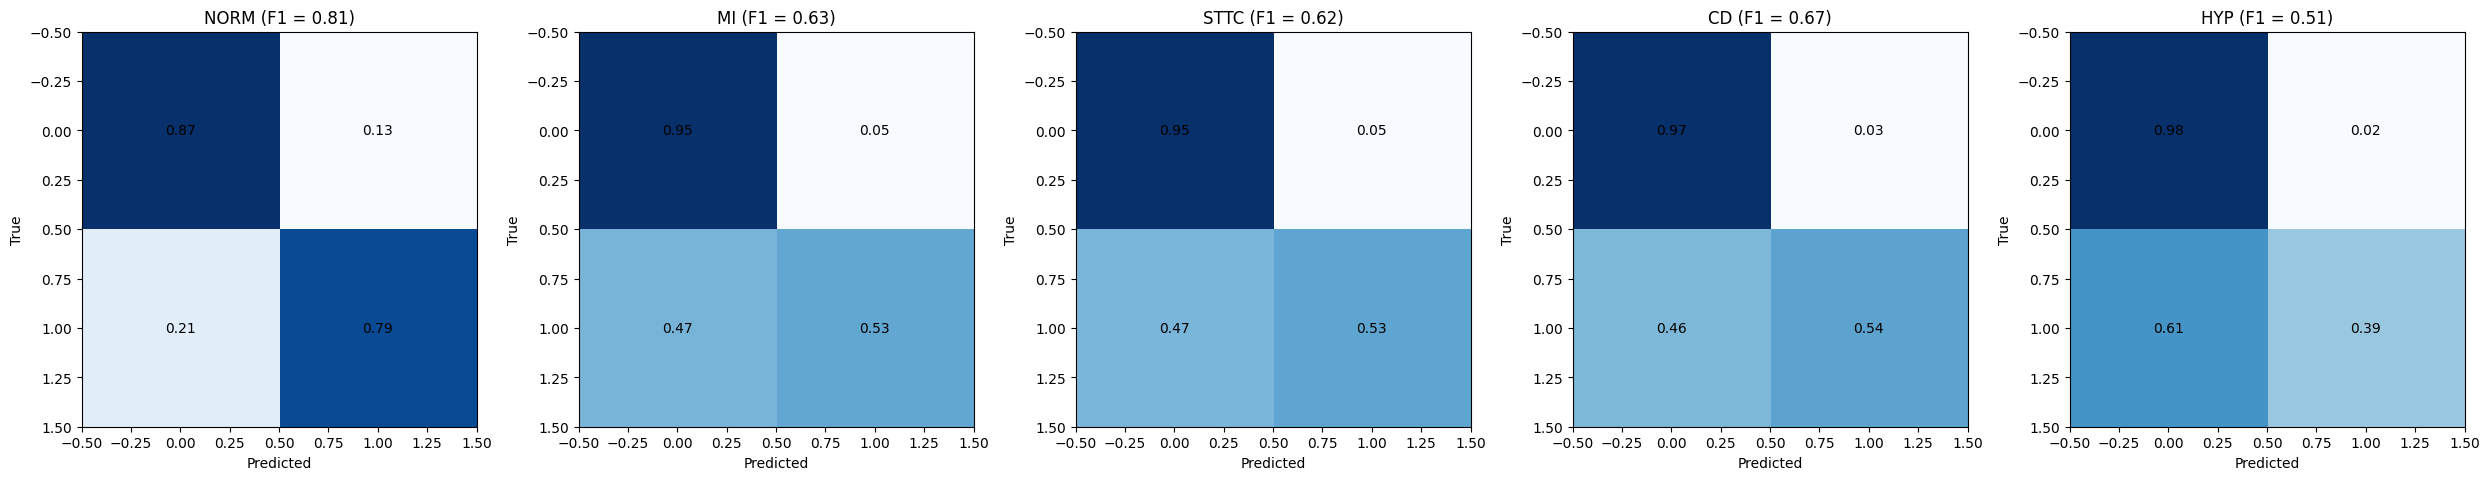

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np

# Superclass column names (first 5)
cols = list(data_preprocessor.superclass_cols)

fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 5 subplots in a row

for i, col in enumerate(cols):
    ax = axes[i]
    
    # Confusion matrix for each superclass (binary classification)
    cm = confusion_matrix(test_labels[:, i], test_pred[:, i])
    cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    
    # F1 score
    fls = f1_score(test_labels[:, i], test_pred[:, i])
    
    # Plot
    im = ax.imshow(cm_norm, cmap=plt.cm.Blues)
    ax.set_title(f'{col} (F1 = {fls:.2f})')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    
    # Add numbers in cells
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            ax.text(k, j, f"{cm_norm[j, k]:.2f}", ha="center", va="center", color="black")

plt.tight_layout()
plt.show()


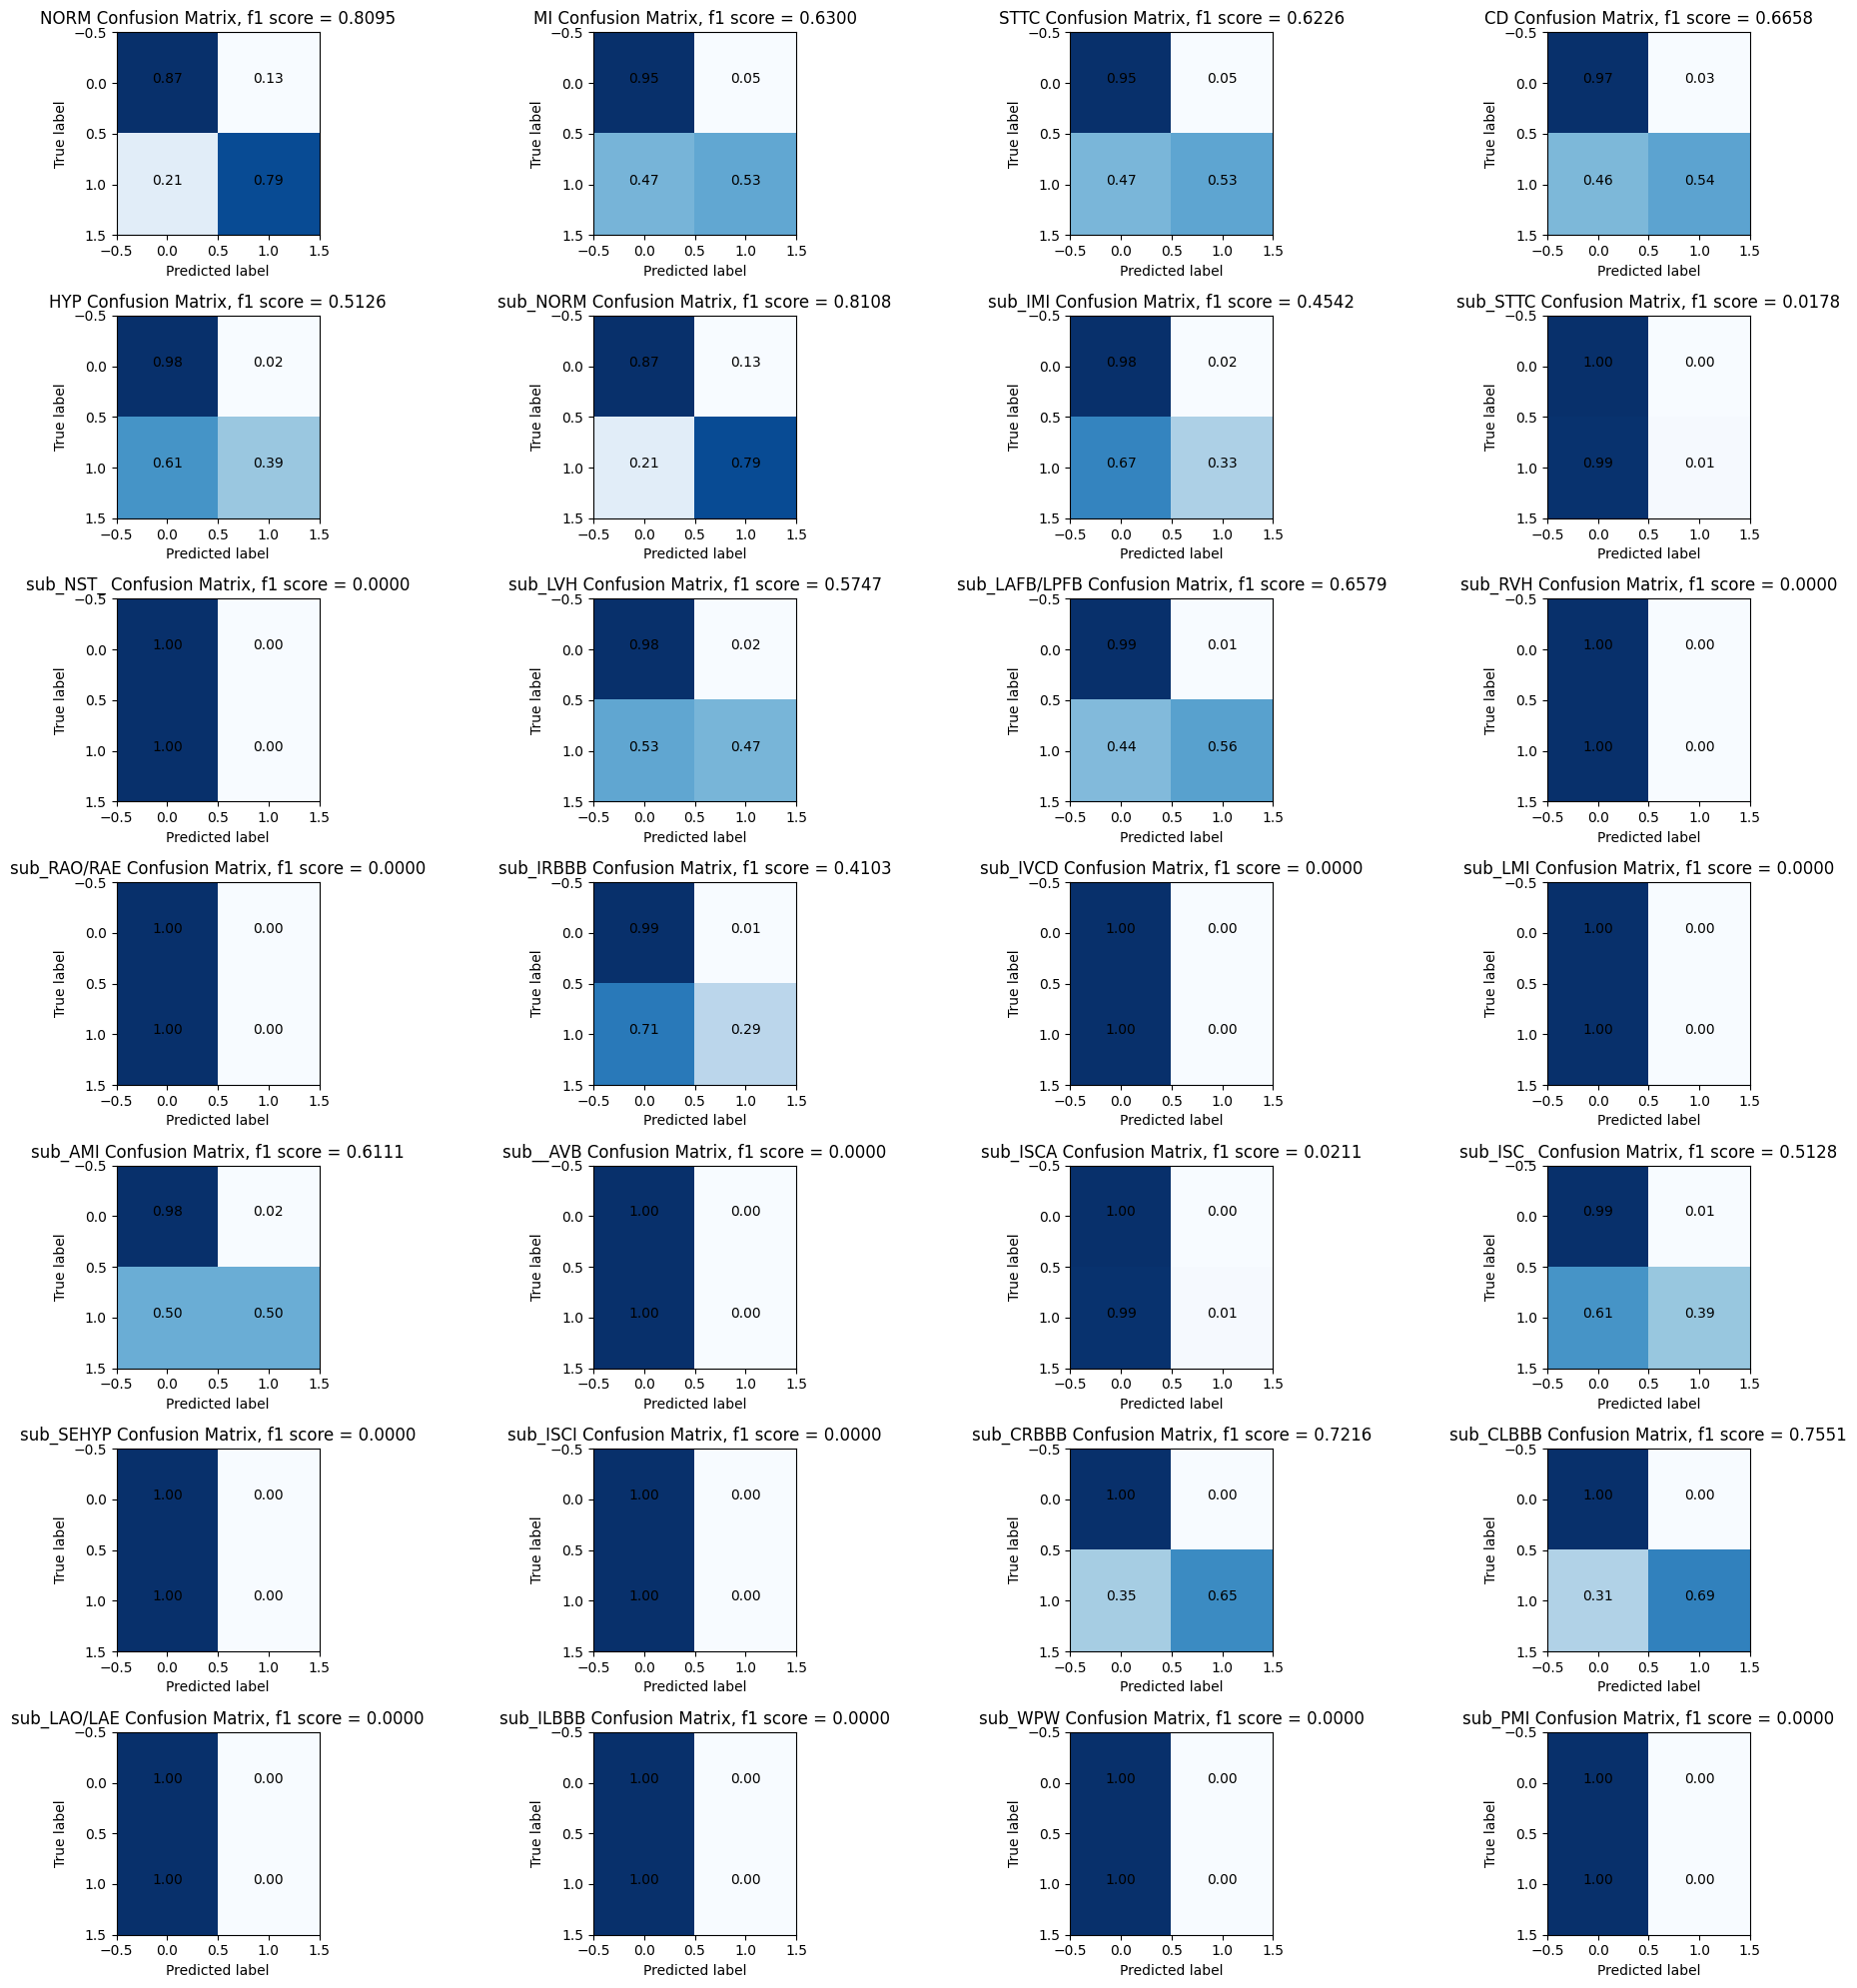

In [35]:
cols = list(data_preprocessor.superclass_cols) + list(data_preprocessor.subclass_cols)
fig, axes = plt.subplots(int(np.ceil(len(cols)/4)), 4, figsize=(20, 20))

for i, col in enumerate(cols):
    
    ax = axes[int(np.floor(i/4)), i%4]
    cm = confusion_matrix(test_labels[:, i], test_pred[:, i])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fls = f1_score(test_labels[:, i], test_pred[:, i])
    
    ax.set_title('{} Confusion Matrix, f1 score = {:.4f}'.format(col, fls))
    
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")
    ax.imshow(cm, cmap=plt.cm.Blues)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

#plt.colorbar()
plt.tight_layout()
plt.show()